<a href="https://colab.research.google.com/github/PseudoPythonista/deep_learning/blob/master/beer_consumption_sao_paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RNN to predict beer consumption for the last 30 days of 2015**

In [81]:
import torch
import torch.nn as nn
import time # for the training loop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("/content/sp_cerveja (1).csv",index_col=0,parse_dates=True)
data.head()

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
Data,,,,,,
2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [82]:
data.isnull().sum()

Temperatura Media (C)          576
Temperatura Minima (C)         576
Temperatura Maxima (C)         576
Precipitacao (mm)              576
Final de Semana                576
Consumo de cerveja (litros)    576
dtype: int64

In [83]:
data.dropna(inplace=True)

In [84]:
data.shape

(365, 6)

In [85]:
data.index.dtype

dtype('<M8[ns]')

In [86]:
data.head()

,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
Data,,,,,,
2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
2015-01-05,"23,82",21,"28,3",0,0.0,28.900


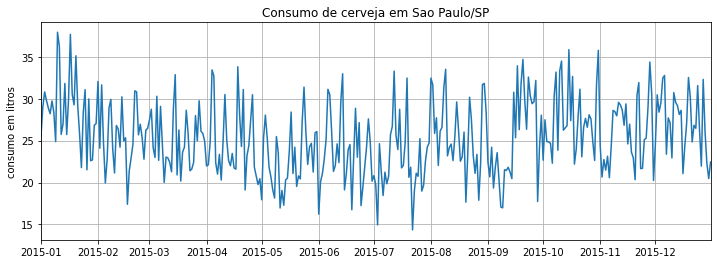

In [87]:
plt.figure(figsize=(12,4))
plt.title('Consumo de cerveja em Sao Paulo/SP')
plt.ylabel('consumo em litros')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['Consumo de cerveja (litros)'])
plt.show()

In [88]:
y = data['Consumo de cerveja (litros)'].values.astype(float) #data for the analysis

test_size = 30 #30 days

# train/test sets
train_set = y[:-test_size] # the whole year up to Dec
test_set = y[-test_size:] # last 30 days

In [89]:
test_set

array([30.471, 28.405, 29.513, 32.451, 32.78 , 23.375, 27.713, 27.137,
       22.933, 30.74 , 29.579, 29.188, 28.131, 28.617, 21.062, 24.337,
       27.042, 32.536, 30.127, 24.834, 26.828, 26.468, 31.572, 26.308,
       21.955, 32.307, 26.095, 22.309, 20.467, 22.446])

In [90]:
#normalize the data to avoid data leakage, then it will be de-normalized, also parameters converge more rapidly

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))#normalize between -1 and 1

In [92]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [93]:
train_norm = torch.FloatTensor(train_norm).view(-1) #train_norm converted into a tensor

In [94]:
window_size = 30 #preferably one season - 30 days = more or less one month
# function defines sq/label tuples
def input_data(seq,ws):  # ws = window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data) # len(y) - train - window

305

In [95]:
train_data[0]

(tensor([-0.0576,  0.2401,  0.3962,  0.3102,  0.2340,  0.1761,  0.3045,  0.1913,
         -0.1063,  1.0000,  0.8573, -0.0337,  0.0721,  0.4819, -0.0353,  0.3219,
          0.9791,  0.3716,  0.2649,  0.7618,  0.2535, -0.0292, -0.3692,  0.1872,
          0.4194, -0.3916,  0.3248, -0.2998, -0.2919,  0.0598]),
 tensor([0.0754]))

In [96]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)#LSTM layer:
        
        self.linear = nn.Linear(hidden_size,output_size)#FC layer
        
        self.hidden = (torch.zeros(1,1,self.hidden_size), #h0 and c0 initialized
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # last value

In [97]:
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [98]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [99]:
epochs = 120
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data: #extract sequence and label
        
        optimizer.zero_grad() # reset param and hidden state
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01463706
Epoch:  2 Loss: 0.00547084
Epoch:  3 Loss: 0.00110739
Epoch:  4 Loss: 0.00037587
Epoch:  5 Loss: 0.00065835
Epoch:  6 Loss: 0.00399876
Epoch:  7 Loss: 0.00432057
Epoch:  8 Loss: 0.00000007
Epoch:  9 Loss: 0.00026519
Epoch: 10 Loss: 0.00062106
Epoch: 11 Loss: 0.00097481
Epoch: 12 Loss: 0.00157526
Epoch: 13 Loss: 0.00089947
Epoch: 14 Loss: 0.00144588
Epoch: 15 Loss: 0.00000947
Epoch: 16 Loss: 0.00108548
Epoch: 17 Loss: 0.00070012
Epoch: 18 Loss: 0.00075304
Epoch: 19 Loss: 0.00000288
Epoch: 20 Loss: 0.00075007
Epoch: 21 Loss: 0.00019683
Epoch: 22 Loss: 0.00436957
Epoch: 23 Loss: 0.00067956
Epoch: 24 Loss: 0.00140186
Epoch: 25 Loss: 0.00300807
Epoch: 26 Loss: 0.00230265
Epoch: 27 Loss: 0.00182615
Epoch: 28 Loss: 0.00330579
Epoch: 29 Loss: 0.00064798
Epoch: 30 Loss: 0.00078038
Epoch: 31 Loss: 0.00277316
Epoch: 32 Loss: 0.00116019
Epoch: 33 Loss: 0.00104655
Epoch: 34 Loss: 0.00049876
Epoch: 35 Loss: 0.00000022
Epoch: 36 Loss: 0.00089238
Epoch: 37 Loss: 0.00113371
E

In [100]:
future = 30

preds = train_norm[-window_size:].tolist() #add last window to the list of preds

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [101]:
preds[window_size:]

[-0.3392549753189087,
 -0.24057011306285858,
 -0.011314723640680313,
 0.17192383110523224,
 0.1531091332435608,
 -0.23467834293842316,
 -0.14845357835292816,
 0.04209286719560623,
 -0.20287299156188965,
 -0.06227293238043785,
 0.705257773399353,
 -0.08139772713184357,
 -0.19296284019947052,
 -0.23758025467395782,
 -0.3098926544189453,
 -0.35821086168289185,
 -0.3151528537273407,
 0.13547030091285706,
 0.45908892154693604,
 -0.21713979542255402,
 -0.20996041595935822,
 -0.2506042718887329,
 -0.4623318612575531,
 -0.32355797290802,
 0.6826837658882141,
 0.2971549928188324,
 -0.03441164270043373,
 -0.13763068616390228,
 -0.3861335217952728,
 -0.15035629272460938]

In [102]:
#invert normalization
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[22.13780906],
       [23.30199438],
       [26.00652021],
       [28.16818544],
       [27.94622844],
       [23.37149959],
       [24.38869314],
       [26.63656955],
       [23.74670732],
       [25.40536622],
       [34.45992595],
       [25.17975101],
       [23.86361737],
       [23.33726574],
       [22.48419636],
       [21.91418646],
       [22.42214178],
       [27.73814314],
       [31.55587201],
       [23.57840183],
       [23.66309697],
       [23.1836214 ],
       [20.68587103],
       [22.32298659],
       [34.19362039],
       [29.64553745],
       [25.73404585],
       [24.5163708 ],
       [21.58478284],
       [24.36624681]])

In [103]:
data["Consumo de cerveja (litros)"][-30:]

Data
2015-12-02    30.471
2015-12-03    28.405
2015-12-04    29.513
2015-12-05    32.451
2015-12-06    32.780
2015-12-07    23.375
2015-12-08    27.713
2015-12-09    27.137
2015-12-10    22.933
2015-12-11    30.740
2015-12-12    29.579
2015-12-13    29.188
2015-12-14    28.131
2015-12-15    28.617
2015-12-16    21.062
2015-12-17    24.337
2015-12-18    27.042
2015-12-19    32.536
2015-12-20    30.127
2015-12-21    24.834
2015-12-22    26.828
2015-12-23    26.468
2015-12-24    31.572
2015-12-25    26.308
2015-12-26    21.955
2015-12-27    32.307
2015-12-28    26.095
2015-12-29    22.309
2015-12-30    20.467
2015-12-31    22.446
Name: Consumo de cerveja (litros), dtype: float64

In [104]:
#original dataset has dates and the predictions don´t, need to re-created
x = np.arange('2015-12-02', '2016-01-01', dtype='datetime64')
x

array(['2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05',
       '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
       '2015-12-10', '2015-12-11', '2015-12-12', '2015-12-13',
       '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17',
       '2015-12-18', '2015-12-19', '2015-12-20', '2015-12-21',
       '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
       '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
       '2015-12-30', '2015-12-31'], dtype='datetime64[D]')

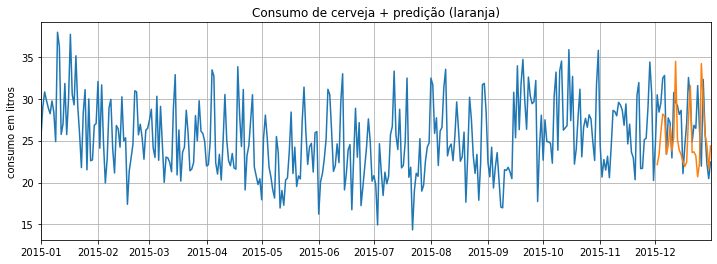

In [105]:
plt.figure(figsize=(12,4))
plt.title('Consumo de cerveja + predição (laranja)')
plt.ylabel('consumo em litros')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['Consumo de cerveja (litros)'])
plt.plot(x,true_predictions)
plt.show()

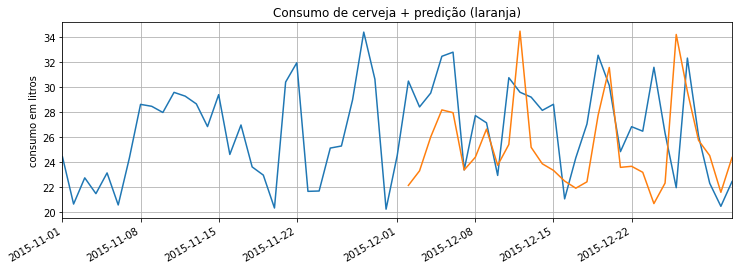

In [106]:
fig = plt.figure(figsize=(12,4))
plt.title('Consumo de cerveja + predição (laranja)')
plt.ylabel('consumo em litros')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(data['Consumo de cerveja (litros)']['2015-11-01':])
plt.plot(x,true_predictions)
plt.show()